# Tutorial: Hallucinating PD-L1 binder
Updated 2021-12-24    
Jue Wang (juewang@post.harvard.edu)

This demonstrates how to use the hallucination script to generate protein-binding proteins.

We will scaffold the interfacial strands of PD-1 against its binding target PD-L1, with the goal of generating de novo mimics of PD-1 that may be tested for the ability to bind to PD-L1. To use as a reference structure for the interface motif, we will use 5IUS, a crystal structure of a PD-1 mutant ("HAC PD-1") with ultra-high affinity for PD-L1.

In [1]:
import sys, glob, os, shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Run 1: Initial hallucination
Start by hallucinating some scaffolds for the PD-1 interface motif.

 - Define the motif as `A63-82` and `A119-140` of 5IUS. These are 2 strand-loop-strand motifs segments that make a beta-sheet that interacts with PD-L1.
 - We also chose lengths of hallucinated regions ("gap lengths") before, between, and after the motifs above. We chose this roughly as a range bracketing the lengths of the same regions in the native protein. These are input, along with the motif residues, as part of the `--mask` argument.
     - An alternative approach is to use the `--contigs` and `--len` arguments, which will place the motifs randomly into a hallucinated protein of a specified total length. This usually has a lower success rate than using gap lengths inspired by nature, but may discover novel topologies.
 - Note all the side chains in the interface motif which interact with (within 5Å and pointing toward) PD-L1. We will keep these amino acids the same as the native with the `--force_aa` option. 
 - Avoid cysteines in the hallucinations to avoid potential problems with expression.
 - Use a repulsive loss to avoid clashes between the hallucination and the binding target. This will only assess clashes between the backbone atoms of the hallucination (RF does not predict side-chains) and the target, at a user-specified distance. More fine-tuned interactions are built in the next stage (run 2, see below).
 - Use a radius of gyration loss to discourage long extended helical structures.

### Generate commands
When testing out the script, you can just call it with a simple set of arguments on the commandline, e.g. 

    ./hallucinate.py --pdb <INPUT.pdb> --mask <MASK> --out <PATH/TO/OUTPUT> 
    
However, for practical production runs it is more convenient to generate the calls to `hallucinate.py` using code so you can have greater control over the arguments, and create many commands for parallel execution on a cluster.

The following code generates a list of commands that may be submitted to a cluster workload manager such as SLURM.
 - working directory is `RFDesign/tutorial/halluc_binder/`
 - we make 20 total designs (in real applications we make 500-10k designs)
 - these are split over 4 commands making 5 designs each
 - the designs are still numbered from 0-19 by using the `--start_num` argument. alternatively you can just give the output filenames a "batch" identifier (e.g. `pd1_r1_b01`)
 - `--track_step 10` outputs a .trk file for each design that contains losses from every 10 steps of gradient descent (or every 100 steps of MCMC)

In [10]:
total_num = 20
batch = 5

ref_pdb = 'input/pd1.pdb'
mask = '25-35,A63-82,15-25,A119-140,0-15' # gap lengths chosen based on corresponding regions in the native protein
force_aa = 'A64,A66,A68,A70,A73-81,A123-124,A127,A128,A132-136,A139'

run_name = 'pd1_r1'
outdir = 'output/run1/'
os.makedirs(outdir, exist_ok=True)

for istart in np.arange(0, total_num, batch):
    cmd = f'source activate SE3; python ../../hallucination/hallucinate.py --pdb={ref_pdb} --out={outdir}{run_name} '\
          f'--mask={mask} --steps=g600 --num={batch} --start_num={istart} '\
          f'--w_rog=1 --rog_thresh=16 --w_rep 2 --rep_pdb input/pdl1.pdb --rep_sigma 4 '\
          f'--save_pdb=True --track_step 10 '\
          f'&>> {outdir}{run_name}_{istart}.log'
    print(cmd)

source activate SE3-nvidia; python ../../hallucination/hallucinate.py --pdb=input/pd1.pdb --out=output/run1/pd1_r1 --mask=25-35,A63-82,15-25,A119-140,0-15 --steps=g600 --num=5 --start_num=0 --w_rog=1 --rog_thresh=16 --w_rep 2 --rep_pdb input/pdl1.pdb --rep_sigma 4 --save_pdb=True --track_step 10 &>> output/run1/pd1_r1_0.log
source activate SE3-nvidia; python ../../hallucination/hallucinate.py --pdb=input/pd1.pdb --out=output/run1/pd1_r1 --mask=25-35,A63-82,15-25,A119-140,0-15 --steps=g600 --num=5 --start_num=5 --w_rog=1 --rog_thresh=16 --w_rep 2 --rep_pdb input/pdl1.pdb --rep_sigma 4 --save_pdb=True --track_step 10 &>> output/run1/pd1_r1_5.log
source activate SE3-nvidia; python ../../hallucination/hallucinate.py --pdb=input/pd1.pdb --out=output/run1/pd1_r1 --mask=25-35,A63-82,15-25,A119-140,0-15 --steps=g600 --num=5 --start_num=10 --w_rog=1 --rog_thresh=16 --w_rep 2 --rep_pdb input/pdl1.pdb --rep_sigma 4 --save_pdb=True --track_step 10 &>> output/run1/pd1_r1_10.log
source activate SE3-

We put these commands into a file `r1.list` and ran it as an array job on SLURM using 
    
    ./gpu_submit.sh r1.list
    
When the run is done, let's add sidechains and relax the structures (this only works on the IPD digs cluster, but you can adapt the underlying code for your system):

    ../../scripts/trfold_relax.sh output/run1/


### Score outputs
Compute AlphaFold2 predictions and their RMSDs against the native pdb and the hallucination design model. (This can also be run on a cpu, although it will be slower and therefore large scoring runs should be split into batches of ~100 outputs). 

    sbatch -p gpu -c 2 --mem 12g --gres gpu:rtx2080:1 --wrap "../../scripts/af2_metrics.py output/run1/trf_relax/"
    
Compute RMSDs between hallucination models and native PDB, along with radius of gyration, secondary structure, etc.

    sbatch --mem 2g --wrap "../../scripts/pyrosetta_metrics.py output/run1/trf_relax/"

Compile all metrics into a single csv (and add some additional metrics, such as rosetta energy, from pdb files).

    ../../scripts/compile_metrics.py output/run1/trf_relax/

### Analyze outputs
Load the metrics, visualize their distributions, and choose hits for followup

In [32]:
df = pd.read_csv('output/run1/trf_relax/combined_metrics.csv')
df['folder'] = 'output/run1/trf_relax/'

In [33]:
df['score_res'] = df['rosetta_energy']/df['len'] # rosetta energy / residue

In [34]:
df.shape

(20, 25)

In [6]:
df.columns

Index(['Unnamed: 0', 'name', 'rosetta_energy', 'loss_tot', 'loss_cce',
       'loss_entropy', 'loss_rep', 'loss_rog', 'contig_rmsd', 'contig_sc_rmsd',
       'rog', 'len', 'seq', 'net_charge', 'ss', 'topology', 'ss_strand_frac',
       'ss_helix_frac', 'ss_loop_frac', 'af2_lddt', 'rmsd_af2_des',
       'contig_rmsd_af2_des', 'contig_rmsd_af2'],
      dtype='object')

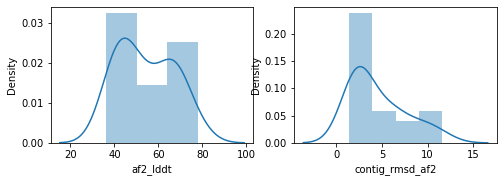

In [9]:
fig,axes = plt.subplots(1,2,figsize=(8,2.5))
for ax,metric in zip(axes.flat, ['af2_lddt','contig_rmsd_af2','rog']):
    sns.distplot(df[metric],ax=ax)

Filter on predicted lddt (a measure of overall scaffold quality), motif ("contig") rmsd between AF2 prediction and native, and radius of gyration. There are several other metrics we will eventually filter on, but at this stage only these metrics are important.

In practice we are looking for af2_lddt > 80 and contig_rmsd_af2 < 1 (ideally closer to 0.5). However, in 20 outputs we are unlikely to obtain designs this good, so lower the thresholds until we get at least one design, so we can continue demonstrating the pipeline.

In [38]:
hits = df[(df['af2_lddt']>60) & (df['contig_rmsd_af2']<1.5) & (df['rog']<16)]

In [39]:
hits.shape

(2, 25)

In [40]:
hits[['name','af2_lddt','contig_rmsd_af2','rog']]

,name,af2_lddt,contig_rmsd_af2,rog
0,pd1_r1_10,68.990048,1.411484,13.841383
19,pd1_r1_13,66.387940,1.452760,13.097704


Copy the hits to their own folder so we can look through them manually and use them as the basis of additional iterations of design.

In [41]:
import shutil

In [42]:
outdir = 'output/hits_r1/'
os.makedirs(outdir, exist_ok=True)
os.makedirs(outdir+'af2/', exist_ok=True)

In [44]:
for i,row in hits.iterrows():
    shutil.copyfile(row['folder']+'/'+row['name']+'.pdb', outdir+row['name']+'.pdb')  
    shutil.copyfile(row['folder']+'af2/'+row['name']+'.pdb', outdir+'af2/'+row['name']+'_af2pred.pdb')    # copy af2 model
    shutil.copyfile(row['folder']+'../'+row['name']+'.trb', outdir+row['name']+'.trb')    
    shutil.copyfile(row['folder']+'../'+row['name']+'.fas', outdir+row['name']+'.fas')    

In [45]:
hits.to_csv(outdir+'metrics.csv')

Align the hits to the native structure and generate a pymol session, so we can inspect them visually.

    ../../scripts/pymol_align.py --template input/pd1.pdb --receptor input/pdl1.pdb --out output/hits_r1/aligned.pse output/hits_r1/*pdb

## Run 2: 2-chain hallucination
Here will will take the hits from run 1 and optimize them further by MCMC in the context of the binding target.
 - On each step, RoseTTAFold will predict the structure of the complex of hallucinated protein and PD-L1 (input to `--receptor` argument). This will allow the method to fine-tune the interface between the proteins and build additional interactions. Only hallucinated binder positions will be mutated -- the binding target will remain its native sequence throughout the trajectory.
 - To save GPU memory, we truncated the PD-L1 structure to 1 domain which interacts with PD-1.
 - We use MCMC instead of gradient descent because it uses less GPU memory, and we don't need that many steps of optimization.
 - We do not use the repulsion loss, as we are directly modeling the binding target.
 - `--spike` and `--spike_fas` tell the script to initialize the hallucination with an existing sequence.
 - `--mask` is used to set the size of hallucinated regions (and therefore the placement of the constrained motif region) exactly as in the parent design.
 - `--use_template` sets up a template input to RoseTTAFold containing the relative transform of the interface motif with respect to the binding target, to make sure the hallucination is being modeled in the correct position relative to PD-L1. A template input is always automatically given for the binding target.

In [9]:
total_num = 10 # number of designs per parent design
batch = 5

ref_pdb = 'input/pd1.pdb'
receptor = 'input/pdl1_trunc.pdb'
force_aa = 'A64,A66,A68,A70,A73-81,A123-124,A127,A128,A132-136,A139'
parent_designs = glob.glob('output/hits_r1/*pdb')

run = 'r2'
outdir = 'output/run2/'
os.makedirs(outdir, exist_ok=True)

for istart in np.arange(0, total_num, batch):
    for fn in parent_designs:
        name = os.path.basename(fn.replace('.pdb',''))
        
        trb = np.load(fn.replace('.pdb','.trb'),allow_pickle=True) # metadata about parent design
        mask = trb['sampled_mask']
        contigs = ','.join([x for x in trb['sampled_mask'].split(',') if x[0]=='A'])
        run_name = name+'_'+run
        
        cmd = f'source activate SE3; python ../../hallucination/hallucinate.py '\
              f'--pdb={ref_pdb} --out={outdir}{run_name} '\
              f'--steps m300 --num={batch} --start_num={istart} '\
              f'--mask {mask} --use_template {contigs} '\
              f'--spike_fas {fn.replace(".pdb",".fas")} --spike 0.999 '\
              f'--force_aa {force_aa} --exclude_aa C '\
              f'--receptor {receptor} --rec_placement second '\
              f'--w_rog=1 --rog_thresh=16 '\
              f'--save_pdb=True --track_step 1 '\
              f'&>> {outdir}{run_name}_{istart}.log'

        print(cmd)

source activate SE3; python ../../hallucination/hallucinate.py --pdb=input/pd1.pdb --out=output/run2/pd1_r1_13_r2 --steps m300 --num=5 --start_num=0 --mask 27-27,A63-82,21-21,A119-140,3-3 --use_template A63-82,A119-140 --spike_fas output/hits_r1/pd1_r1_13.fas --spike 0.999 --force_aa A64,A66,A68,A70,A73-81,A123-124,A127,A128,A132-136,A139 --exclude_aa C --receptor input/pdl1_trunc.pdb --rec_placement second --w_rog=1 --rog_thresh=16 --save_pdb=True --track_step 1 &>> output/run2/pd1_r1_13_r2_0.log
source activate SE3; python ../../hallucination/hallucinate.py --pdb=input/pd1.pdb --out=output/run2/pd1_r1_10_r2 --steps m300 --num=5 --start_num=0 --mask 29-29,A63-82,16-16,A119-140,7-7 --use_template A63-82,A119-140 --spike_fas output/hits_r1/pd1_r1_10.fas --spike 0.999 --force_aa A64,A66,A68,A70,A73-81,A123-124,A127,A128,A132-136,A139 --exclude_aa C --receptor input/pdl1_trunc.pdb --rec_placement second --w_rog=1 --rog_thresh=16 --save_pdb=True --track_step 1 &>> output/run2/pd1_r1_10_r2_

We put these commands into a file `r2.list` and ran it as an array job on SLURM using 
    
    ./gpu_submit.sh r2.list
    
When the run is done, make models (this command works on both monomer and 2-chain hallucination outputs):

    ../../scripts/trfold_relax.sh output/run2/


### Score outputs
Calculate Rosetta interface metrics:

    sbatch --mem 5g --wrap "../../scripts/get_interface_metrics.py output/run2/trf_relax/"
